In [2]:
setwd("D:/2.crc_trio/results/")
dir="D:/2.crc_trio/draft/toZL/Reviewer/"

library(openxlsx)
library(dplyr)
library(reshape2)

library(ggrepel)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(ggsci)
library(cowplot)
library(ggpmisc)
library(ggsignif)

In [3]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/Drivers_v3.RData")

In [4]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/Input_v2.RData")

In [5]:
ls()

[1] "bamdst"             "cutoff"             "dat"               
 [4] "dir"                "ls_escc_af"         "maf_driver_snv_all"
 [7] "Top50_driver"       "Top50_genedat"      "Top50_geneMatrix"  
[10] "Top50_genestat"     "tt"

In [19]:
clin2<-read.xlsx("./0.库检/8.肠镜标本病理_HE核对r4toYu.xlsx",sheet = 1,colNames = T,cols = c(1:20))

In [20]:
clin2 %>% select(PatientID,P_grade_mo,P_grade_zhu,P_grade,P_diameter) %>% tail(n=2)

,PatientID,P_grade_mo,P_grade_zhu,P_grade,P_diameter
,<chr>,<chr>,<chr>,<chr>,<dbl>
126,B126,High,High,High,4.5
127,B127,NA,NA,NA,1.2


In [21]:
p_dat<-dat %>% filter(grepl('P$',Sample))

p_dat<-right_join(clin2 %>% select(PatientID,P_grade_mo,P_grade_zhu,P_grade,P_diameter) %>% mutate(P_size=ifelse(is.na(P_diameter),'NA',ifelse(P_diameter<1,'Small','Large')  ) ),
                  p_dat,by=c('PatientID'='Patient'))

In [22]:
p_dat %>% head(n=2)

,PatientID,P_grade_mo,P_grade_zhu,P_grade,P_diameter,P_size,Sample,Clonal,Subclonal,ClonalSNP,...,TCRA.tcell.fraction.adj.upr,highTcellFlag,AMP,DEL,FLA,Age,Lineage,wGII,CIN_status,Clonal_CCF_Mean
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,...,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,B001,Low,High,High,1.15,Large,B001P,0,189,0,...,0.341,FALSE,0.06,0.28,0.34,51,Polyclonal,0.2918182,CIN-,NaN
2,B002,High,High,High,2.25,Large,B002P,146,70,132,...,0.274,FALSE,10.35,6.41,16.76,70,Monoclonal,23.2695455,CIN+,1.04


In [23]:
p_dat %>% colnames()

[1] "PatientID"                   "P_grade_mo"                 
 [3] "P_grade_zhu"                 "P_grade"                    
 [5] "P_diameter"                  "P_size"                     
 [7] "Sample"                      "Clonal"                     
 [9] "Subclonal"                   "ClonalSNP"                  
[11] "SubclonalSNP"                "Frame_Shift_Del"            
[13] "Frame_Shift_Ins"             "In_Frame_Del"               
[15] "In_Frame_Ins"                "Missense_Mutation"          
[17] "Nonsense_Mutation"           "Nonstop_Mutation"           
[19] "Splice_Site"                 "Translation_Start_Site"     
[21] "total_nonsilent"             "NonSilent_SNV"              
[23] "total_SNP"                   "total_DEL"                  
[25] "total_INS"                   "total_MNP"                  
[27] "TMB"                         "derived"                    
[29] "ClonalDriver"                "SubDriver"                  
[31] "TotalDriver"                 "Total_Number_of_Sites"      
[33] "Number_of_Somatic_Sites"     "MSIscore"                   
[35] "MSItype"                     "dmmr"                       
[37] "HLA_Loss"                    "HLA_Loss_Allele_Counts"     
[39] "purity"                      "ploidy"                     
[41] "depth"                       "neo_clonal"                 
[43] "neo_subclonal"               "neo_clonal_ccf"             
[45] "TCRA.cn"                     "TCRA.tcell.fraction"        
[47] "TCRA.tcell.fraction.lwr"     "TCRA.tcell.fraction.upr"    
[49] "TCRA.tcell.fraction.adj"     "TCRA.tcell.fraction.adj.lwr"
[51] "TCRA.tcell.fraction.adj.upr" "highTcellFlag"              
[53] "AMP"                         "DEL"                        
[55] "FLA"                         "Age"                        
[57] "Lineage"                     "wGII"                       
[59] "CIN_status"                  "Clonal_CCF_Mean"

In [24]:
mytheme1= theme_bw()+theme(panel.grid = element_blank(),
                   panel.border= element_blank(),
                   plot.title = element_text(hjust = 0.5))+
  theme(legend.position = "right",
        legend.title  = element_text(size=8),
        legend.text = element_text(size=8),
        legend.key.size =unit(0.2,'cm') ) +
  theme(axis.text = element_text(size=10,colour = "black"),
        axis.ticks = element_line(size=0.5),
        axis.title = element_text(size=12,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )

In [25]:
mytheme=theme(panel.grid = element_blank(),
        panel.background = element_blank(),
        legend.position ="none",
        legend.text = element_text(size = 8, colour = 'black'),
        axis.line = element_line(color = 'black',size = 0.5),
        axis.text = element_text(size = 10, colour = 'black'),
        axis.ticks = element_line(size=0.5),
        axis.title = element_text(size = 12, colour = 'black'),
        strip.background = element_blank(),
        strip.text.x = element_text(size=10,colour = "black",face = "bold.italic")
  )

In [26]:
p_size_count=p_dat %>% filter(purity>=0.25) %>% mutate(Lineage=ifelse(grepl('Monoclonal',Lineage),'P_mono','P_poly')) %>% 
           group_by(P_size,Lineage) %>% count %>% as.data.frame %>% rename(c("Sample"="n")) %>% filter(grepl('Large|Small',P_size))
p_size_count
pVal<-fisher.test(t(matrix(p_size_count$Sample,nrow = 2)))
pVal

g1_1=p_dat %>% filter(purity>=0.25) %>% mutate(Lineage=ifelse(grepl('Monoclonal',Lineage),'P_mono','P_poly')) %>% 
group_by(P_size,Lineage) %>% count %>% as.data.frame %>% rename(c("Sample"="n")) %>% filter(grepl('Large|Small',P_size)) %>%
ggbarplot(x = "P_size",y = "Sample",label = TRUE,lab.pos = "in",lab.col = 'white' ,xlab = "",fill = "Lineage",color = 'white',alpha=0.8)+
  scale_fill_lancet()+ylab("No.samples")+xlab('Polyp size')+
  stat_signif(comparisons = list(c("Large","Small")),annotations =signif(pVal$p.value,3) ,y_position = 60)+ mytheme1+guides(fill = guide_legend(title = "Clonality"))

P_size,Lineage,Sample
<chr>,<chr>,<int>
Large,P_mono,48
Large,P_poly,10
Small,P_mono,19
Small,P_poly,19



	Fisher's Exact Test for Count Data

data:  t(matrix(p_size_count$Sample, nrow = 2))
p-value = 0.001222
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  1.723648 13.663457
sample estimates:
odds ratio 
  4.712371 


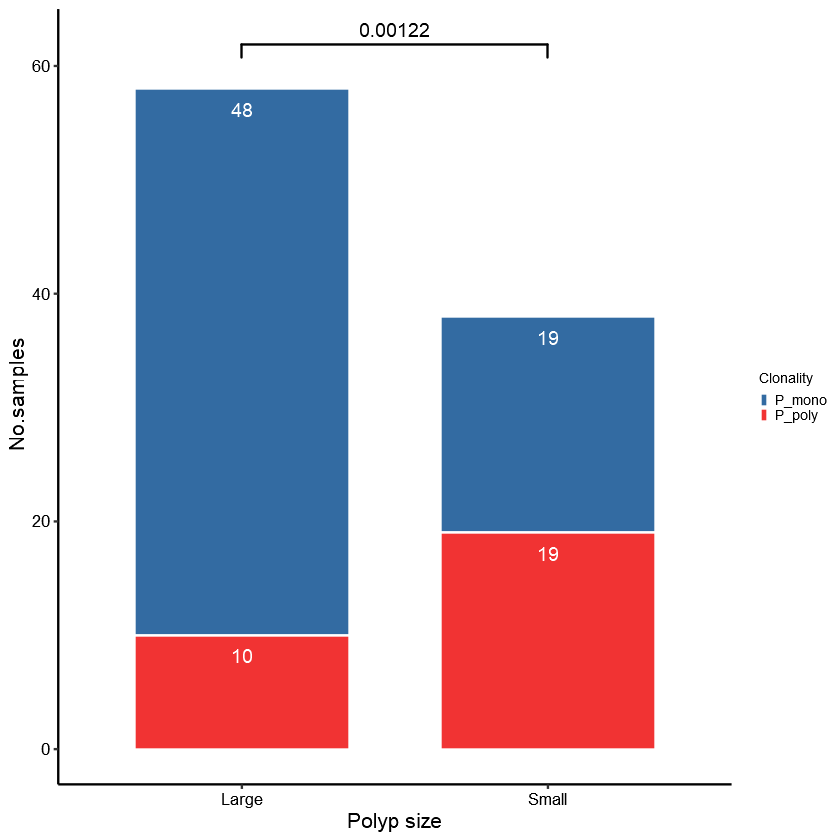

In [27]:
print(g1_1)

In [28]:
p_grade_count=p_dat %>% filter(purity>=0.25) %>% mutate(Lineage=ifelse(grepl('Monoclonal',Lineage),'P_mono','P_poly')) %>% 
             group_by(P_grade,Lineage) %>% count %>% as.data.frame %>% rename(c("Sample"="n")) %>% filter(grepl('High|Low',P_grade))
p_grade_count
pVal<-fisher.test(t(matrix(p_grade_count$Sample,nrow = 2)))
pVal

g2_1=p_dat %>% filter(purity>=0.25) %>% mutate(Lineage=ifelse(grepl('Monoclonal',Lineage),'P_mono','P_poly')) %>% 
group_by(P_grade,Lineage) %>% count %>% as.data.frame %>% rename(c("Sample"="n")) %>% filter(grepl('High|Low',P_grade)) %>%
ggbarplot(x = "P_grade",y = "Sample",label = TRUE,lab.pos = "in",lab.col = 'white' ,xlab = "",fill = "Lineage",color = 'white',alpha=0.8)+
  scale_fill_lancet()+ylab("No.samples")+xlab('Polyp grade')+
  stat_signif(comparisons = list(c("High","Low")),annotations =signif(pVal$p.value,3) ,y_position = 51)+
  mytheme1+guides(fill = guide_legend(title = "Clonality"))

P_grade,Lineage,Sample
<chr>,<chr>,<int>
High,P_mono,44
High,P_poly,7
Low,P_mono,22
Low,P_poly,22



	Fisher's Exact Test for Count Data

data:  t(matrix(p_grade_count$Sample, nrow = 2))
p-value = 0.0001498
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  2.137548 19.827427
sample estimates:
odds ratio 
  6.153513 


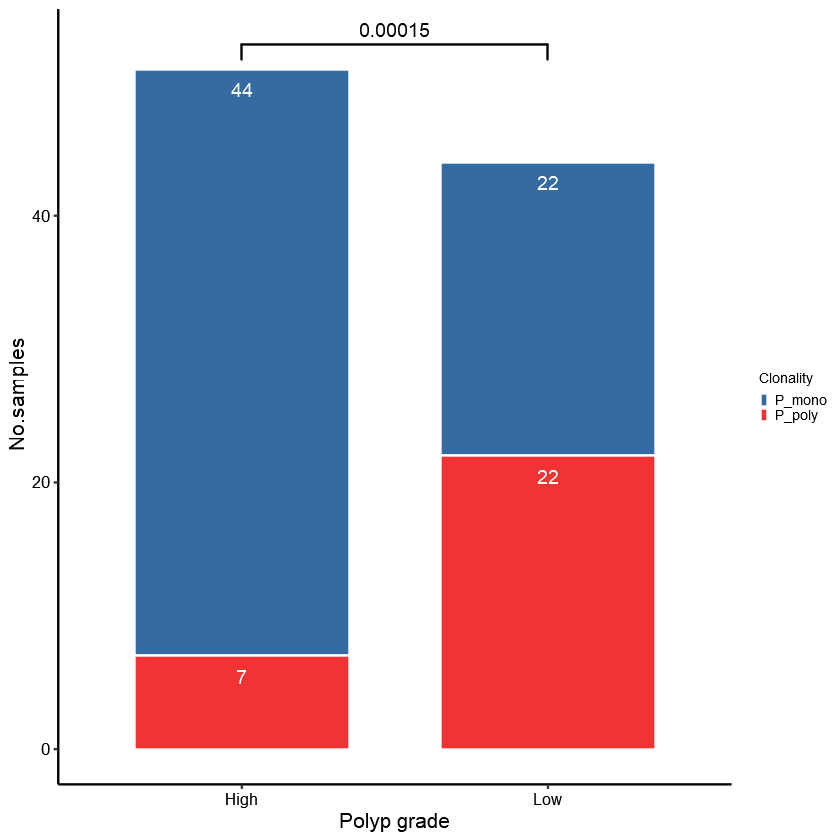

In [29]:
print(g2_1)